# CheXagent disease classification on [NIH Chest X-ray data](https://www.kaggle.com/datasets/nih-chest-xrays/sample/data)


###### Imports


In [ ]:
import io
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from PIL import Image
from rich import print
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    hamming_loss,
    jaccard_score,
    multilabel_confusion_matrix,
    precision_score,
    recall_score,
)
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.svm import SVC
from skmultilearn.dataset import load_dataset
from skmultilearn.problem_transform import BinaryRelevance

sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

GOLDEN = (1 + 5**0.5) / 2

###### Function definitions


In [33]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content)).convert("RGB")


def generate(images, prompt, processor, model, device, dtype, generation_config):
    inputs = processor(
        images=images[:2], text=f" USER: <s>{prompt} ASSISTANT: <s>", return_tensors="pt"
    ).to(device=device, dtype=dtype)
    output = model.generate(
        **inputs,
        generation_config=generation_config,
        # this silences "Setting `pad_token_id` to `eos_token_id`:{eos_token_id} for open-end generation."
        pad_token_id=processor.tokenizer.eos_token_id,
    )[0]
    response = processor.tokenizer.decode(output, skip_special_tokens=True)
    return response


def disp_df(dataframe):
    display(dataframe.head())
    print(f"nRows: {dataframe.shape[0]:,}\tnColumns: {dataframe.shape[1]}")


def plot_img(image, title):
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()


def get_prompt_groups(prompts):
    prompt_groups = {}
    prompt_groups.update({key: "A" for key in prompts.keys() if int(key) <= 10})
    prompt_groups.update(
        {key: "B" for key in prompts.keys() if ((int(key) >= 11) and (int(key) <= 20))}
    )
    prompt_groups.update(
        {key: "C" for key in prompts.keys() if ((int(key) >= 21) and (int(key) <= 30))}
    )
    prompt_groups.update({key: "D" for key in prompts.keys() if (int(key) >= 31)})

    return prompt_groups


def get_ypred(response, labels):
    return [label for label in labels if label in response]


def get_tps(series):
    tps = [x for x in series["y_pred"] if x in series["y_true"]]
    return tuple(tps)


def get_fps(series):
    fps = [x for x in series["y_pred"] if x not in series["y_true"]]
    return tuple(fps)


def get_tns(series, labels):
    tns = [x for x in labels if (x not in series["y_true"]) and (x not in series["y_pred"])]
    return tuple(tns)


def get_fns(series):
    fns = [x for x in series["y_true"] if x not in series["y_pred"]]
    return tuple(fns)


def get_sample_metrics(dataframe, labels):
    def combined_metrics(x):
        tps = get_tps(x)
        fps = get_fps(x)
        tns = get_tns(x, labels)
        fns = get_fns(x)
        return len(tps), len(fps), len(tns), len(fns)

    tps_len, fps_len, tns_len, fns_len = zip(*dataframe.apply(combined_metrics, axis=1))

    acc = (dataframe["y_pred"] == dataframe["y_true"]).astype(int)

    tps_len_series = pd.Series(tps_len, index=dataframe.index)
    fps_len_series = pd.Series(fps_len, index=dataframe.index)
    tns_len_series = pd.Series(tns_len, index=dataframe.index)
    fns_len_series = pd.Series(fns_len, index=dataframe.index)

    sensitivity = tps_len_series / (tps_len_series + fns_len_series)
    prec = tps_len_series / (tps_len_series + fps_len_series)
    f1 = (2 * ((prec * sensitivity) / (prec + sensitivity))).fillna(0.0)

    return_df = pd.DataFrame(
        {
            "tps_len": tps_len_series,
            "fps_len": fps_len_series,
            "tns_len": tns_len_series,
            "fns_len": fns_len_series,
            "accuracy": acc,
            "sensitivity": sensitivity,
            "precision": prec,
            "f1": f1,
        }
    )

    return return_df


def compute_mlc_metrics_wide(df, labels):
    y_true = df["y_true"]
    y_pred = df["y_pred"]
    mlb = MultiLabelBinarizer(classes=labels)
    ytrue = mlb.fit_transform(y_true)
    ypred = mlb.fit_transform(y_pred)
    support = ytrue.sum(axis=0)

    # Multi-label averaging parameter options: "macro", "weighted", "micro", "samples", and None
    avg = None

    index_label_zero_div_map = {0.0: "0", 1.0: "1", "warn": "warn", np.nan: "nan"}

    metrics_wide = pd.DataFrame()
    for zero_div in [0.0, 1.0, np.nan]:

        # zero-div param for jaccard score cannot be NAN
        if isinstance(zero_div, float) and np.isnan(zero_div):
            zero_div_j = 0.0
        else:
            zero_div_j = zero_div
        index_label_zero_div = index_label_zero_div_map[zero_div]

        jaccard = jaccard_score(ytrue, ypred, average=avg, zero_division=zero_div_j)
        precision = precision_score(ytrue, ypred, average=avg, zero_division=zero_div)
        sensitivity = recall_score(ytrue, ypred, average=avg, zero_division=zero_div)
        f1 = f1_score(ytrue, ypred, average=avg, zero_division=zero_div)
        # specificity is the True Negative Rate, so calc recall on the negative class
        specificity = recall_score(
            (ytrue == 0).astype(int), (ypred == 0).astype(int), average=avg, zero_division=zero_div
        )

        df_i = pd.DataFrame(
            np.vstack([jaccard, precision, sensitivity, f1, specificity, support]),
            columns=mlb.classes_.tolist(),
            index=["jaccard", "precision", "sensitivity", "f1", "specificity", "support"],
        )
        df_i.index.name = "metric"
        df_i["zerodiv_opt"] = index_label_zero_div
        df_i = df_i.reset_index()
        df_i = df_i[["zerodiv_opt", "metric"] + mlb.classes_.tolist()]

        metrics_wide = pd.concat([metrics_wide, df_i], ignore_index=True)

    metrics_wide = metrics_wide.sort_values("metric").reset_index(drop=True)

    return metrics_wide


def compute_mlc_metrics(df, labels):
    y_true = df["y_true"]
    y_pred = df["y_pred"]
    mlb = MultiLabelBinarizer(classes=labels)
    ytrue = mlb.fit_transform(y_true)
    ypred = mlb.fit_transform(y_pred)
    support = ytrue.shape[0]

    index_label_zero_div_map = {0.0: "0", 1.0: "1", "warn": "warn", np.nan: "nan"}

    metrics = pd.DataFrame(
        columns=[
            "avg_opt",
            "zerodiv_opt",
            "accuracy",
            "hammingloss",
            "jaccard",
            "precision",
            "sensitivity",
            "f1",
            "specificity",
            "support",
        ]
    )

    idx = 0
    for avg in ["macro", "weighted", "micro", "samples"]:
        for zero_div in [0.0, 1.0, np.nan]:
            # set avg param index label
            if avg:
                index_label_avg = avg
            else:
                index_label_avg = "none"

            # zero-div param for jaccard score cannot be NAN
            if isinstance(zero_div, float) and np.isnan(zero_div):
                zero_div_j = 0.0
            else:
                zero_div_j = zero_div
            index_label_zero_div = index_label_zero_div_map[zero_div]

            accuracy = accuracy_score(ytrue, ypred)
            # fraction of labels that are incorrectly predicted
            hammingloss = hamming_loss(ytrue, ypred)
            jaccard = jaccard_score(ytrue, ypred, average=avg, zero_division=zero_div_j)
            precision = precision_score(ytrue, ypred, average=avg, zero_division=zero_div)
            sensitivity = recall_score(ytrue, ypred, average=avg, zero_division=zero_div)
            f1 = f1_score(ytrue, ypred, average=avg, zero_division=zero_div)
            # specificity is the True Negative Rate, so calc recall on the negative class
            specificity = recall_score(
                (ytrue == 0).astype(int),
                (ypred == 0).astype(int),
                average=avg,
                zero_division=zero_div,
            )

            metrics.loc[idx, :] = (
                index_label_avg,
                index_label_zero_div,
                accuracy,
                hammingloss,
                jaccard,
                precision,
                sensitivity,
                f1,
                specificity,
                support,
            )
            idx += 1
    metrics[
        [
            "accuracy",
            "hammingloss",
            "jaccard",
            "precision",
            "sensitivity",
            "f1",
            "specificity",
            "support",
        ]
    ] = metrics.loc[
        :,
        [
            "accuracy",
            "hammingloss",
            "jaccard",
            "precision",
            "sensitivity",
            "f1",
            "specificity",
            "support",
        ],
    ].astype(
        float
    )
    return metrics

## NIH Chest X-ray dataset


###### Load dataset


In [ ]:
column_names = ["image_index", "finding_labels", "follow_up_number", "patient_id", "patient_age", "patient_gender", "view_position", "original_image_width", "original_image_height", "original_image_pixel_spacing_x", "original_image_pixel_spacing_y"]  # fmt: skip # nopep8

data = pd.read_csv(
    "./data/NIH_Chest_X-ray_Dataset/Data_Entry_2017.csv",
    names=column_names,
    header=0,
    index_col=False,
)
display(data.head())
print(f"Rows: {data.shape[0]:,}\tColumns: {data.shape[1]}")
print(f"Number of patients: {data['patient_id'].nunique():,}")

###### Visualize data


In [ ]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
sns.countplot(x=data["patient_gender"])
plt.gca().set(title="Distribution of Patient Gender", xlabel=None, ylabel="Counts")

plt.subplot(2, 3, 2)
sns.histplot(data=data[data["patient_age"] < 130], x="patient_age", bins=20, kde=True)
plt.gca().set(title="Distribution of Patient Age", xlabel="Age", ylabel="Counts")

# Create boolean columns for each pathology type
pathology_list = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"]  # fmt: skip # nopep8
for pathology in pathology_list:
    data[pathology] = data["finding_labels"].apply(lambda x: 1 if pathology in x else 0)

data["No_Findings"] = data["finding_labels"].apply(lambda x: 1 if "No Finding" in x else 0)

plt.subplot(2, 3, 3)
sns.barplot(data.iloc[:, 11:-1].sum(axis=1).value_counts(), orient="h")
plt.gca().set(title="Number of findings per image", xlabel="Counts", ylabel="Number of findings")

# Sum of values across selected columns and reset index for Seaborn
sum_data = data.iloc[:, 11:].sum().reset_index()
sum_data.columns = ["Feature", "Total"]

plt.subplot(2, 3, 4)
sns.barplot(x="Total", y="Feature", data=sum_data)
plt.gca().set(title="Disease Classes", xlabel="Counts", ylabel=None)

plt.subplot(2, 3, 5)
sns.barplot(x="Total", y="Feature", data=sum_data.loc[sum_data["Feature"] != "No_Findings", :])
plt.gca().set(title="Disease Classes (exluding no disease class)", xlabel="Counts", ylabel=None)
plt.tight_layout()
plt.show()

###### remove calculated columns


In [ ]:
data = data[column_names]

## Analyze prompts and responses


###### import results


In [34]:
# filelist = [x.as_posix() for x in Path("output").rglob("disease_classification_QA*.csv")]
# filelist = [x.as_posix() for x in Path("output").rglob("CheXagent_results_on_NIH_CXR.csv.gz")]
filelist = [x.as_posix() for x in Path("output/NIH_Chest_Xray_IRFrelevant_findings").rglob("tmp_*")]
results = pd.DataFrame()
for f in filelist:
    df_i = pd.read_csv(
        f, usecols=["image_index", "finding_labels", "prompt_key", "response"], dtype=str
    )
    results = pd.concat([results, df_i])

results = results.drop_duplicates(ignore_index=True)

labels = (
    "Atelectasis",  # relevant to IRF work
    # "Cardiomegaly",
    "Consolidation",  # relevant to IRF work
    # "Edema",
    "Effusion",  # relevant to IRF work
    # "Emphysema",
    # "Fibrosis",
    # "Hernia",
    "Infiltration",  # relevant to IRF work
    # "Mass",
    # "Nodule",
    # "Pleural_Thickening",
    "Pneumonia",  # relevant to IRF work
    # "Pneumothorax",
    "No Finding",  # relevant to IRF work
)
results["y_true"] = results["finding_labels"].str.split("|")
results["y_pred"] = results["response"].apply(lambda x: get_ypred(x, labels))
results["n_labels"] = results["y_true"].apply(len)
results["response_num_findings"] = results["y_pred"].apply(len)

mlb = MultiLabelBinarizer(classes=labels, sparse_output=False)
ytrue = mlb.fit_transform(results["y_true"])
ypred = mlb.fit_transform(results["y_pred"])

# make "prompt_key" categorical
# prompt_file_list = Path("data").glob("prompts*")
prompt_file_list = Path("data").glob("prompts_ref*")
prompts = {}
for prompt_file in prompt_file_list:
    with open(prompt_file.as_posix(), "r") as json_file:
        data = json.load(json_file)
        prompts.update(data)

prompt_key_order = [int(key) for key in prompts.keys()]
prompt_key_order.sort()
prompt_key_order = [str(key) for key in prompt_key_order]

results["prompt_key"] = pd.Categorical(
    results["prompt_key"], ordered=True, categories=prompt_key_order
)

prompt_groups = get_prompt_groups(prompts)
results["prompt_group"] = results["prompt_key"].map(prompt_groups)
cols = ["image_index", "finding_labels", "prompt_key", "prompt_group", "response", "y_true", "y_pred", "n_labels", "response_num_findings"]  # fmt: skip # nopep8
results = results[cols]
cols = ["tps_len", "fps_len", "tns_len", "fns_len", "accuracy", "sensitivity", "precision", "f1"]  # fmt: skip # nopep8
results[cols] = get_sample_metrics(results, labels)

# remove outlier case
# results = results.loc[results["response_num_findings"] != 0, :]

results = results.sort_values(["image_index", "prompt_key"], ignore_index=True)

disp_df(results)

,image_index,finding_labels,prompt_key,prompt_group,response,y_true,y_pred,n_labels,response_num_findings,tps_len,fps_len,tns_len,fns_len,accuracy,sensitivity,precision,f1
0,00000002_000.png,No Finding,31,D,No Finding,[No Finding],[No Finding],1,1,1,0,5,0,1,1.0,1.0,1.0
1,00000002_000.png,No Finding,32,D,No Finding,[No Finding],[No Finding],1,1,1,0,5,0,1,1.0,1.0,1.0
2,00000002_000.png,No Finding,33,D,No Finding,[No Finding],[No Finding],1,1,1,0,5,0,1,1.0,1.0,1.0
3,00000002_000.png,No Finding,34,D,No Finding,[No Finding],[No Finding],1,1,1,0,5,0,1,1.0,1.0,1.0
4,00000002_000.png,No Finding,35,D,No Finding,[No Finding],[No Finding],1,1,1,0,5,0,1,1.0,1.0,1.0


nRows: 247,952  nColumns: 17

In [35]:
[print(f"{key}: {val}") for key, val in prompts.items()]

31: Examine this x-ray image and identify if any of these conditions are present: Atelectasis, Consolidation, 
Effusion, Infiltration, or Pneumonia. If none of these are visible, respond with 'No Finding.'

32: Analyze this x-ray image carefully and identify whether it shows signs of Atelectasis, Consolidation, Effusion,
Infiltration, or Pneumonia. If none of these conditions are present, reply 'No Finding.'

33: Please review this x-ray image and confirm if each of these conditions is visible: Atelectasis, Consolidation, 
Effusion, Infiltration, Pneumonia. If none are present, reply 'No Finding.'

34: Analyze the given x-ray image and list any of the following conditions that are present: Atelectasis, 
Consolidation, Effusion, Infiltration, Pneumonia. If none of these conditions are found, respond with 'No Finding'.

35: Examine the provided chest x-ray image. Check for the presence of Atelectasis, Consolidation, Effusion, 
Infiltration, or Pneumonia. If any of these conditions are detected, list their names in the response. If the image
appears normal, reply with 'No Finding'.

36: Based on the input x-ray image, determine if any of the following abnormalities are present: Atelectasis, 
Consolidation, Effusion, Infiltration, Pneumonia. Respond with a comma-separated list of the detected conditions. 
If no abnormalities are found, respond with 'No Finding'.

37: Please interpret the given x-ray image and check for signs of Atelectasis, Consolidation, Effusion, 
Infiltration, or Pneumonia. If the image exhibits characteristics of any of these conditions, include their names 
in the response. If the image appears normal with no signs of these conditions, reply with 'No Finding'.

38: Analyze the provided chest x-ray for the following conditions: Atelectasis, Consolidation, Effusion, 
Infiltration, Pneumonia. List the names of any detected conditions, separated by commas. If none of these 
conditions are present, respond with 'No Finding'.

[None, None, None, None, None, None, None, None]

In [36]:
# dv = results.sample(1000)

#### Evaluate MLC task of the different prompts

[Comprehensive comparative study of multi-label classification methods](https://doi.org/10.1016/j.eswa.2022.117215)

4.5 Statistical evaluation if performance of the methods are statisitically significant:

- corrected Friedman test (non-parametric multiple hypothesis test)
- post-hoc Nemenyi test


In [37]:
# df1 = results[results["prompt_group"] == "A"].copy()
# df2 = results[results["prompt_group"] == "B"].copy()
# df3 = results[results["prompt_group"] == "C"].copy()
# df4 = results[results["prompt_group"] == "D"].copy()

##### Reproduce `sklearn` metrics


In [38]:
# # subset results
# df_res = results[results["prompt_key"] == "31"].copy()

# disp_df(df_res)

In [39]:
# # Isolate one particular label and analyze one binary case
# true_0, pred_0 = ytrue[df_res.index][:, 0], ypred[df_res.index][:, 0]
# temp = pd.DataFrame({"true": true_0, "pred": pred_0})

# temp["true_pos"] = 0.0
# temp.loc[(temp["true"] == 1) & (temp["pred"] == 1), "true_pos"] = 1

# temp["true_neg"] = 0.0
# temp.loc[(temp["true"] == 0) & (temp["pred"] == 0), "true_neg"] = 1

# temp["false_pos"] = 0.0
# temp.loc[(temp["true"] == 0) & (temp["pred"] == 1), "false_pos"] = 1

# temp["false_neg"] = 0.0
# temp.loc[(temp["true"] == 1) & (temp["pred"] == 0), "false_neg"] = 1

# disp_df(temp)

# val_binary = recall_score(true_0, pred_0, average="binary", zero_division=0.0)
# val_micro = recall_score(true_0, pred_0, average="micro", zero_division=0.0)
# val_macro = recall_score(true_0, pred_0, average="macro", zero_division=0.0)
# print(f"sensitivity(avg='binary'): {val_binary}")
# print(f"sensitivity(avg='micro' or 'weighted'): {val_micro}")
# print(f"sensitivity(avg='macro'): {val_macro}")

# # this matches average = "binary"
# val = temp["true_pos"].sum() / (temp["true_pos"].sum() + temp["false_neg"].sum())
# print(f"replicate metric for avg='binary': {val}")

# # this matches average = "micro" or "weighted"
# val = (temp["true_pos"].sum() + temp["true_neg"].sum()) / temp.shape[0]
# print(f"replicate metric for avg='micro' or 'weighted': {val}")

# # this matches average = "macro"
# val = recall_score(true_0, pred_0, average=None, zero_division=0.0).mean()
# print(f"replicate metric for avg='macro': {val}")

In [40]:
# metrics_wide = compute_mlc_metrics_wide(df_res, labels)
# metrics = compute_mlc_metrics(df_res, labels)
# display(metrics_wide)
# display(metrics)

In [41]:
# metrics_wide.drop_duplicates(subset=metrics_wide.select_dtypes(include="number").columns)

In [42]:
# metrics.drop_duplicates(subset=metrics.select_dtypes(include="number").columns)

In [43]:
# metrics.set_index(["avg_opt", "zerodiv_opt"]).iloc[:, -4:].rank(ascending=False)

In [44]:
# metrics.set_index(["avg_opt", "zerodiv_opt"]).iloc[:, -4:].rank(ascending=False).mean(
#     axis=1
# ).sort_values()

#### Plots


##### Confusion matrix


In [45]:
prompt_keys = results["prompt_key"].unique()

df_agg_wide = pd.DataFrame()
df_agg = pd.DataFrame()
for prompt_key in prompt_keys:
    df_input = results[results["prompt_key"] == prompt_key].copy()

    metrics_wide_i = compute_mlc_metrics_wide(df_input, labels)
    metrics_wide_i["prompt_key"] = prompt_key
    df_agg_wide = pd.concat([df_agg_wide, metrics_wide_i], ignore_index=True)

    metrics_i = compute_mlc_metrics(df_input, labels)
    metrics_i["prompt_key"] = prompt_key
    df_agg = pd.concat([df_agg, metrics_i], ignore_index=True)

df_agg["prompt_group"] = df_agg["prompt_key"].map(prompt_groups)
df_agg_wide["prompt_group"] = df_agg_wide["prompt_key"].map(prompt_groups)

display(df_agg_wide)
display(df_agg)

,zerodiv_opt,metric,Atelectasis,Consolidation,Effusion,Infiltration,Pneumonia,No Finding,prompt_key,prompt_group
0,nan,f1,0.151617,0.183673,0.311015,0.089260,0.054326,0.275979,31,D
1,0,f1,0.151617,0.183673,0.311015,0.089260,0.054326,0.275979,31,D
2,1,f1,0.151617,0.183673,0.311015,0.089260,0.054326,0.275979,31,D
3,0,jaccard,0.082027,0.101124,0.184143,0.046715,0.027921,0.160079,31,D
4,1,jaccard,0.082027,0.101124,0.184143,0.046715,0.027921,0.160079,31,D
...,...,...,...,...,...,...,...,...,...,...
139,0,specificity,0.778291,0.852208,0.866684,0.863233,0.948055,0.306155,38,D
140,1,specificity,0.778291,0.852208,0.866684,0.863233,0.948055,0.306155,38,D
141,1,support,8460.000000,3090.000000,8371.000000,14316.000000,885.000000,4527.000000,38,D
142,0,support,8460.000000,3090.000000,8371.000000,14316.000000,885.000000,4527.000000,38,D


,avg_opt,zerodiv_opt,accuracy,hammingloss,jaccard,precision,sensitivity,f1,specificity,support,prompt_key,prompt_group
0,macro,0,0.153739,0.324509,0.100335,0.339173,0.256725,0.177645,0.814382,30994.0,31,D
1,macro,1,0.153739,0.324509,0.100335,0.339173,0.256725,0.177645,0.814382,30994.0,31,D
2,macro,nan,0.153739,0.324509,0.100335,0.339173,0.256725,0.177645,0.814382,30994.0,31,D
3,weighted,0,0.153739,0.324509,0.100029,0.461963,0.207017,0.177281,0.802440,30994.0,31,D
4,weighted,1,0.153739,0.324509,0.100029,0.461963,0.207017,0.177281,0.802440,30994.0,31,D
...,...,...,...,...,...,...,...,...,...,...,...,...
91,micro,1,0.157256,0.316362,0.204909,0.306260,0.382406,0.340123,0.765267,30994.0,38,D
92,micro,nan,0.157256,0.316362,0.204909,0.306260,0.382406,0.340123,0.765267,30994.0,38,D
93,samples,0,0.157256,0.316362,0.249378,0.258568,0.367110,0.284496,0.761448,30994.0,38,D
94,samples,1,0.157256,0.316362,0.249378,0.258568,0.367110,0.284496,0.761448,30994.0,38,D


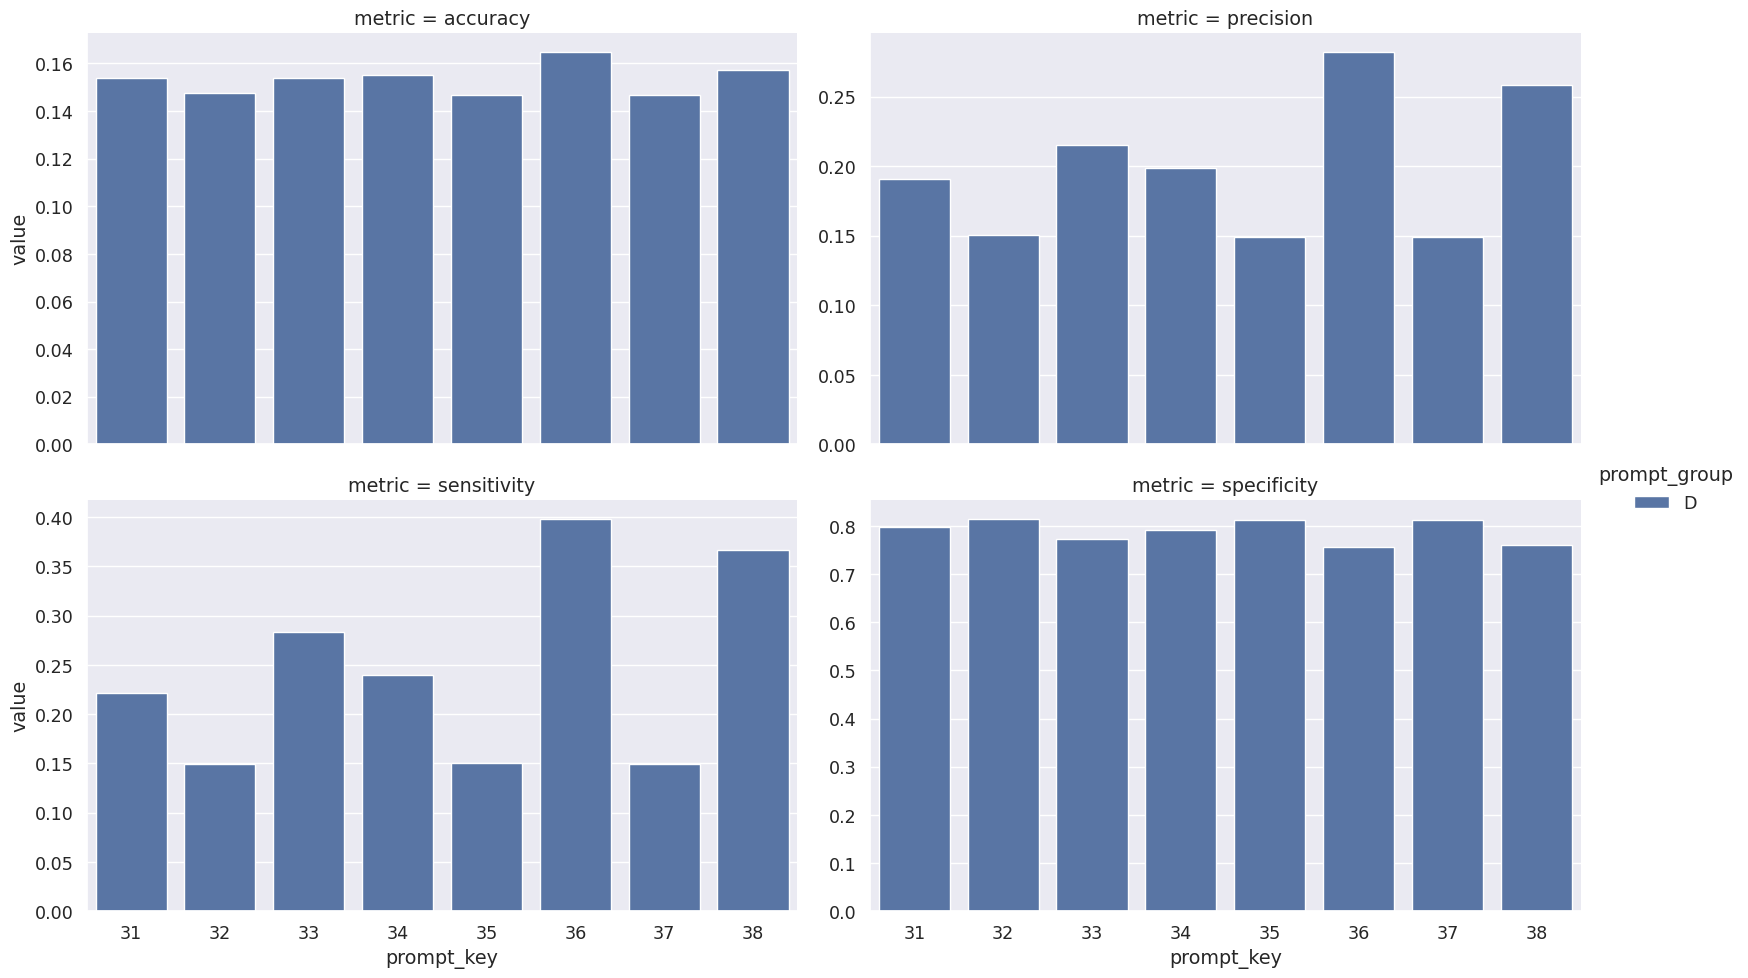

In [46]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

plotdf = (
    df_agg.loc[df_agg["zerodiv_opt"] == "nan"]
    .loc[df_agg["avg_opt"] == "samples"]
    .drop(columns=["avg_opt", "zerodiv_opt"])
    .melt(id_vars=["prompt_key", "prompt_group"], var_name="metric")
    .pipe(lambda x: x[x["metric"].isin(["accuracy", "precision", "sensitivity", "specificity"])])
)
plotdf["prompt_key"] = pd.Categorical(plotdf["prompt_key"].astype(int))
plotdf = plotdf.sort_values(["metric", "prompt_key"], ignore_index=True)

g = sns.catplot(
    data=plotdf,
    x="prompt_key",
    y="value",
    hue="prompt_group",
    col="metric",
    col_wrap=2,
    kind="bar",
    sharey=False,
    aspect=GOLDEN,
)

In [47]:
# # re-create plot from results dataframe
# sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

# plotdf = results.melt(
#     id_vars=["image_index", "prompt_key", "prompt_group", "y_true", "y_pred"],
#     value_vars=["accuracy", "sensitivity", "precision"],
#     var_name="metric",
# )
# plotdf["prompt_key"] = pd.Categorical(plotdf["prompt_key"].astype(int))
# # plotdf = plotdf.sort_values(["metric", "prompt_key"], ignore_index=True)

# g = sns.catplot(
#     data=plotdf,
#     x="prompt_key",
#     y="value",
#     hue="prompt_group",
#     col="metric",
#     col_wrap=1,
#     col_order=["accuracy", "precision", "sensitivity"],
#     kind="bar",
#     sharey=False,
#     aspect=GOLDEN,
# )

In [48]:
results[~results["finding_labels"].str.contains("Atelectasis")].groupby("prompt_key").size()

/data/scratch/rustadmd/ai-hpcgpu19/ipykernel_361773/3760688541.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  results[~results["finding_labels"].str.contains("Atelectasis")].groupby("prompt_key").size()


prompt_key
31    22534
32    22534
33    22534
34    22534
35    22534
36    22534
37    22534
38    22534
dtype: int64

In [49]:
results[
    ~results["finding_labels"].str.contains("Atelectasis")
    & ~results["y_pred"].apply(lambda x: "Atelectasis" in x)
].groupby("prompt_key").size()

/data/scratch/rustadmd/ai-hpcgpu19/ipykernel_361773/2608098514.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ].groupby("prompt_key").size()


prompt_key
31    20595
32    22514
33    18965
34    20343
35    22485
36    16533
37    22533
38    17538
dtype: int64

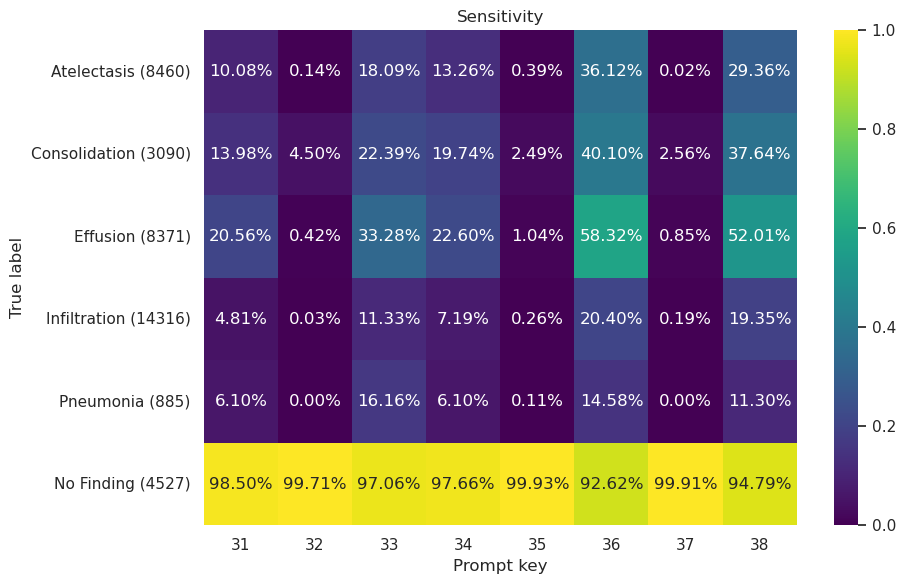

In [50]:
sns.set_theme(context="notebook", style="white", font_scale=1.)

plotdf = (
    df_agg_wide.loc[df_agg_wide["zerodiv_opt"] == "nan"]
    .loc[df_agg_wide["metric"] == "sensitivity"]
    .drop(columns=["zerodiv_opt", "metric", "prompt_group"])
    .set_index("prompt_key")
    .T
)

support_map = (
    df_agg_wide.loc[df_agg_wide["zerodiv_opt"] == "nan"]
    .loc[df_agg_wide["metric"].isin(["support"])]
    .drop(columns=["zerodiv_opt", "metric", "prompt_group", "prompt_key"])
    .median()
    .astype(int)
    .to_dict()
)

plt.figure(figsize=(GOLDEN * 6, 6))
ax = sns.heatmap(plotdf, annot=True, fmt=".2%", cmap="viridis", vmin=0, vmax=1)

yticklabels = ax.get_yticklabels()
new_yticklabels = [f"{label.get_text()} ({support_map[label.get_text()]})" for label in yticklabels]
ax.set_yticklabels(new_yticklabels)

ax.set(
    title="Sensitivity",
    xlabel="Prompt key",
    ylabel="True label",
)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

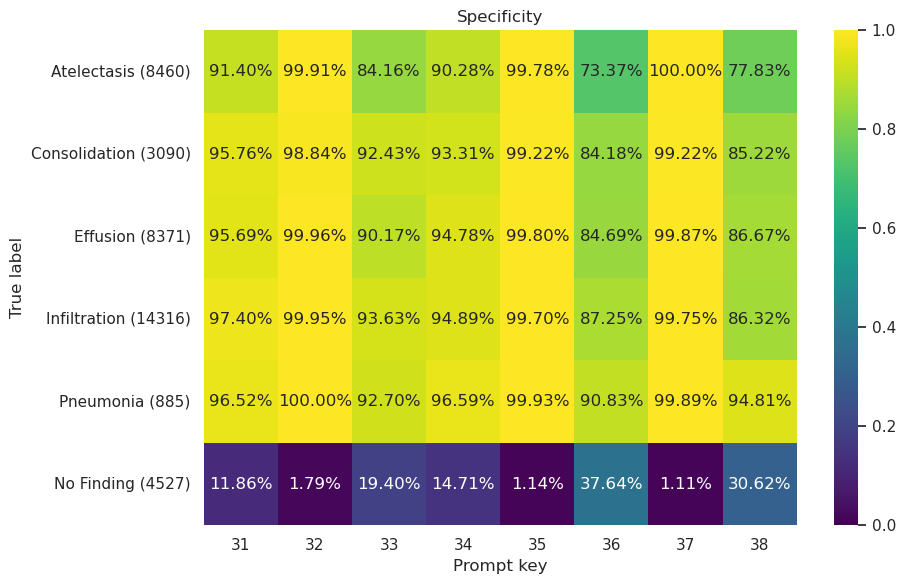

In [51]:
sns.set_theme(context="notebook", style="white", font_scale=1.)

plotdf = (
    df_agg_wide.loc[df_agg_wide["zerodiv_opt"] == "nan"]
    .loc[df_agg_wide["metric"] == "specificity"]
    .drop(columns=["zerodiv_opt", "metric", "prompt_group"])
    .set_index("prompt_key")
    .T
)

support_map = (
    df_agg_wide.loc[df_agg_wide["zerodiv_opt"] == "nan"]
    .loc[df_agg_wide["metric"].isin(["support"])]
    .drop(columns=["zerodiv_opt", "metric", "prompt_group", "prompt_key"])
    .median()
    .astype(int)
    .to_dict()
)

plt.figure(figsize=(GOLDEN * 6, 6))
ax = sns.heatmap(plotdf, annot=True, fmt=".2%", cmap="viridis", vmin=0, vmax=1)

yticklabels = ax.get_yticklabels()
new_yticklabels = [f"{label.get_text()} ({support_map[label.get_text()]})" for label in yticklabels]
ax.set_yticklabels(new_yticklabels)

ax.set(
    title="Specificity",
    xlabel="Prompt key",
    ylabel="True label",
)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

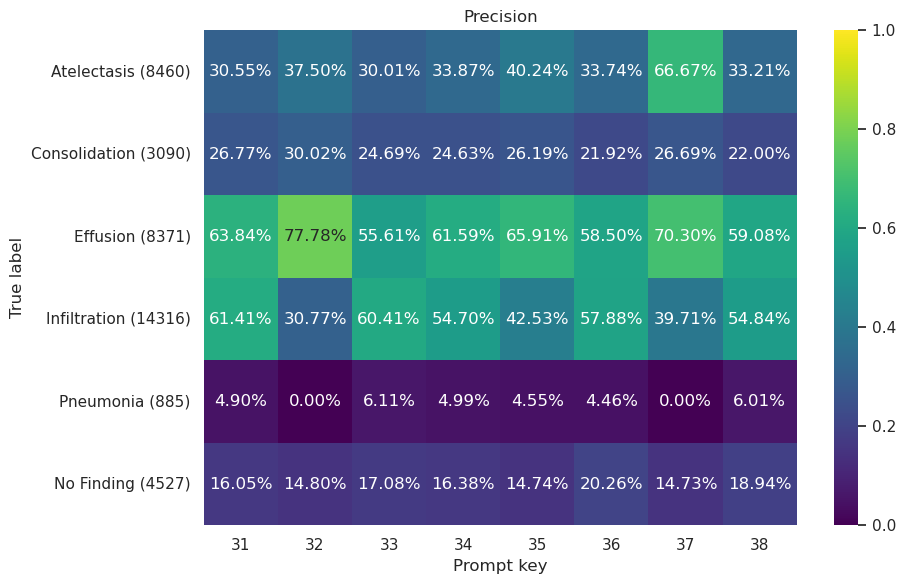

In [52]:
sns.set_theme(context="notebook", style="white", font_scale=1.)

plotdf = (
    df_agg_wide.loc[df_agg_wide["zerodiv_opt"] == "nan"]
    .loc[df_agg_wide["metric"] == "precision"]
    .drop(columns=["zerodiv_opt", "metric", "prompt_group"])
    .set_index("prompt_key")
    .T
)
support_map = (
    df_agg_wide.loc[df_agg_wide["zerodiv_opt"] == "nan"]
    .loc[df_agg_wide["metric"].isin(["support"])]
    .drop(columns=["zerodiv_opt", "metric", "prompt_group", "prompt_key"])
    .median()
    .astype(int)
    .to_dict()
)

plt.figure(figsize=(GOLDEN * 6, 6))
ax = sns.heatmap(plotdf, annot=True, fmt=".2%", cmap="viridis", vmin=0, vmax=1)

yticklabels = ax.get_yticklabels()
new_yticklabels = [f"{label.get_text()} ({support_map[label.get_text()]})" for label in yticklabels]
ax.set_yticklabels(new_yticklabels)

ax.set(
    title="Precision",
    xlabel="Prompt key",
    ylabel="True label",
)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

plotdf = (
    df_agg_wide.loc[df_agg_wide["zerodiv_opt"] == "nan"]
    .loc[df_agg_wide["metric"] == "precision"]
    # .loc[df_agg_wide["prompt_key"].astype(int).isin(np.arange(1, 11))]
    # .loc[df_agg_wide["prompt_key"].astype(int).isin(np.arange(11, 21))]
    # .loc[df_agg_wide["prompt_key"].astype(int).isin(np.arange(21, 31))]
    .drop(columns=["zerodiv_opt"])
    .melt(id_vars=["metric", "prompt_key"], var_name="class")
)
plotdf["prompt_key"] = pd.Categorical(plotdf["prompt_key"].astype(int))
plotdf = plotdf.sort_values(["prompt_key", "class", "metric"], ignore_index=True)
g = sns.catplot(
    data=plotdf,
    x="prompt_key",
    y="value",
    col="class",
    col_wrap=3,
    kind="bar",
    sharey=True,
    aspect=1.602,
)

In [ ]:
# Compute confusion matrices for each class
mcm = multilabel_confusion_matrix(ytrue, ypred)


# Function to plot confusion matrices for each class
def plot_multilabel_confusion_matrix(mcm, classes):
    fig, axes = plt.subplots(
        nrows=int(len(classes) / 2) + len(classes) % 2,
        ncols=2,
        figsize=(10, 4 * int(len(classes) / 2)),
    )
    for i, (cm, class_name) in enumerate(zip(mcm, classes)):
        ax = axes.flatten()[i]
        sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues")
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        ax.set_title(f"Class: {class_name}")
        ax.xaxis.set_ticklabels(["Negative", "Positive"])
        ax.yaxis.set_ticklabels(["Negative", "Positive"])

    plt.tight_layout()
    plt.show()


# Plotting the confusion matrices
plot_multilabel_confusion_matrix(mcm, mlb.classes_)

In [ ]:
conf_matrices = {label: {"TP": 0, "FP": 0, "TN": 0, "FN": 0} for label in labels}


def update_conf_matrix(row, label):
    if label in row["true_positives"]:
        conf_matrices[label]["TP"] += 1
    if label in row["false_positives"]:
        conf_matrices[label]["FP"] += 1
    if label in row["true_negatives"]:
        conf_matrices[label]["TN"] += 1
    if label in row["false_negatives"]:
        conf_matrices[label]["FN"] += 1


for label in labels:
    results.apply(lambda row: update_conf_matrix(row, label), axis=1)


conf_matrices

In [ ]:
sns.set_theme(style="white")

for label, matrix in conf_matrices.items():
    cm = np.array([[matrix["TP"], matrix["FP"]], [matrix["FN"], matrix["TN"]]])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

##### Histogram on `response_num_findings`


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(ytrue, ypred, average="weighted")

In [ ]:
results.head().apply(lambda x: 1 if len(get_tps(x)) > 0 else 0, axis=1)

In [ ]:
results.head().apply(lambda x: 1 if len(get_tps(x)) > 0 else 0, axis=1)

In [ ]:
get_sample_metrics(results, labels)

In [ ]:
plotdf = results.copy()
col_list = [
    "tps_len",
    "fps_len",
    "tns_len",
    "fns_len",
    "accuracy",
    "sensitivity",
    "precision",
    "specificity",
    "f1",
]
plotdf[col_list] = get_sample_metrics(plotdf, labels)

plotdf

In [ ]:
mlb.transform(dv.y_true)

In [ ]:
mlb.transform(dv.y_pred)

In [ ]:
# dv.loc[dv.y_true == ("",), "y_true"] = ()

In [ ]:
np.reshape(labels, (1, len(labels)))

In [ ]:
def prfs(series, mlb):
    labels = mlb.classes_

    # y_pred = ("",) if series["y_pred"] == () else series["y_pred"]

    y_pred = np.reshape(series["y_pred"], (1, len(series["y_pred"])))
    y_true = np.reshape(series["y_true"], (1, len(series["y_true"])))

    y_pred = mlb.transform(y_pred).flatten()
    y_true = mlb.transform(y_true).flatten()

    return precision_recall_fscore_support(y_true, y_pred)

In [ ]:
a = ([1.0], [1.0], [1.0], [14])
np.ravel(a)

In [ ]:
mlb.transform(dv["y_true"])

In [ ]:
mlb.transform(dv["y_pred"])

In [ ]:
transformed_array = np.hstack((mlb.transform(dv["y_true"]), mlb.transform(dv["y_pred"]))).reshape(
    (dv.shape[0], 2, len(mlb.classes_))
)
display(transformed_array)

In [ ]:
x = [
    np.array(
        precision_recall_fscore_support(yt, yp, average="samples", zero_division=0.0)
    ).flatten()
    for yt, yp in transformed_array
]

In [ ]:
x

In [ ]:
pd.DataFrame(np.vstack(x))

In [ ]:
[len(a) for a in x]

In [ ]:
dv.apply(
    lambda x: prfs(x, mlb),
    axis=1,
)

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)
plotdf = results.copy()
g = sns.displot(
    data=plotdf,
    x="response_num_findings",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    hue="prompt_key",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Prompt Key")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    hue="prompt_key",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Prompt Key")
g.figure.suptitle("Share of no. of findings within generated response by prompt")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    hue="finding_labels",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="GT label")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    hue="finding_labels",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="GT label")
g.figure.suptitle("Share of no. of findings within generated response by GT label")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    col="prompt_key",
    col_wrap=5,
    height=3.5,
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    # palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "right", title="Label in response")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings",
    col="prompt_key",
    col_wrap=5,
    height=3.5,
    hue="finding_labels",
    multiple="stack",
    discrete=True,
    palette="tab20",
)

g.set_axis_labels(x_var="Resp. number of findings")
g.legend.set_title("Finding")
g.tight_layout()
plt.show()

##### Histogram on `prompt_key`


In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="Prompt Key")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Is label in generated response?")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="label_in_response",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="Prompt Key", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Share of generated responses with correct label")
g.tight_layout()
plt.show()

In [ ]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="response_num_findings",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="Prompt Key", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(0.85, 0.5), title="No. labels\nin response")
g.figure.suptitle("Share of number of findings within generated response by prompt")
g.tight_layout()
plt.show()

##### Heatmaps


In [ ]:
sns.set_theme(style="white")

plotdf = (
    results.groupby(["prompt_key", "response_num_findings"], observed=True)
    .size()
    .reset_index()
    .pivot(columns="prompt_key", index="response_num_findings", values=0)
    .iloc[::-1]
)

plt.figure(figsize=(GOLDEN * 6, 6))
ax = sns.heatmap(plotdf, annot=True, fmt=".0f")
ax.set(
    title="Number of findings in response by prompt",
    xlabel="Prompt Key",
    ylabel="Number of findings in response",
)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
sns.set_theme(style="white", font_scale=1)

plotdf = (
    results.groupby(["finding_labels", "response_num_findings"], observed=True)
    .size()
    .reset_index()
    .pivot(columns="finding_labels", index="response_num_findings", values=0)
    .transform(lambda x: (x / x.sum()) * 100)
    .iloc[::-1]
)

plt.figure(figsize=(GOLDEN * 8, 8))
ax = sns.heatmap(plotdf, annot=True, fmt=".1f")
ax.set(
    title="Number of findings in response by disease\n(values are percentages, columns sum to 100%)",
    xlabel="Disease",
    ylabel="Number of findings in response",
)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Multi-finding imags


In [ ]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.relplot(
    data=results,
    x="response_num_findings",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()